In [1]:
import pandas as pd

In [2]:
import json
import os

In [3]:
data_test = pd.read_json("./data/test_set.json")

In [4]:
import numpy as np
import pickle

In [6]:
#### READS in CHGNET convergence files - I will provide separately
chgnet_data = []

for i in range(len(data_test)):
    curr_row = data_test.iloc[i]
    curr_id = curr_row.unrelaxed_cryst_id
    
    if os.path.isfile("./inference/James_Scrap/Stored_Opt/CHGnet_traj"+str(curr_id)):
        f = open("./inference/James_Scrap/Stored_Opt/CHGnet_traj"+str(curr_id),"rb") 
        relax_data = pickle.load(f) 
        chgnet_data.append(relax_data["energy"][-1])
        # Closing file 
        f.close() 

chgnet_data = np.asarray(chgnet_data)

In [7]:
len(chgnet_data)

1261

In [9]:
from pymatgen.entries.computed_entries import ComputedEntry
from inference.James_Scrap.MP_custom_corrections import MaterialsProject2020Custom
from pymatgen.core import Structure

In [10]:
import re


def get_elements(formula):
    elements = re.findall(r'([A-Z][a-z]?)', formula)
    return set(elements)

def get_run_type(formula):
    elements = get_elements(formula)
    U_elements = ["V","Cr","Mn","Fe","Co","Ni","W","Mo"]
    if "O" in elements:
        for U_element in U_elements:
            if U_element in elements:
                return "GGA+U"
        
    return "GGA"

def get_u_settings(formula):
    elements = get_elements(formula)
    if "F" in elements:
        return {"Co": 3.32, "Cr": 3.7, "Fe": 5.3, "Mn": 3.9, "Mo": 4.38, "Ni": 6.2, "V": 3.25, "W": 6.2}
    elif "O" in elements:
        return {"Co": 3.32, "Cr": 3.7, "Fe": 5.3, "Mn": 3.9, "Mo": 4.38, "Ni": 6.2, "V": 3.25, "W": 6.2}
    else:
        return {}

In [11]:
def get_entry(datapoint):
    comp = Structure.from_dict(datapoint["unrelaxed_struct"]).composition
    energy = datapoint["dft_energy"]
    formula = comp.formula
    
    return ComputedEntry(comp, energy, parameters = {"potcar_symbols":[],"run_type":get_run_type(formula),"hubbards":get_u_settings(formula)})

all_entries_copy = []


for i in range(len(data_test)):
    all_entries_copy.append(get_entry(data_test.iloc[i]))

In [17]:
compat = MaterialsProject2020Custom()

In [18]:
adjustments = []
for entry in all_entries_copy:
    adjustments.append(compat.get_adjustments(entry))

/home/jypeng/publication_repos/PerovskiteOrderingGCNNs/inference/James_Scrap/MP_custom_corrections.py:182: UserWarning: No structure or oxide_type parameter present. Note that peroxide/superoxide corrections are not as reliable and relies only on detection of special formulas, e.g., Li2O2.
  warnings.warn(
/home/jypeng/publication_repos/PerovskiteOrderingGCNNs/inference/James_Scrap/MP_custom_corrections.py:234: UserWarning: Failed to guess oxidation states for Entry None (Ba3Ca5CoNi7O24). Assigning anion correction to only the most electronegative atom.
  warnings.warn(
/home/jypeng/publication_repos/PerovskiteOrderingGCNNs/inference/James_Scrap/MP_custom_corrections.py:234: UserWarning: Failed to guess oxidation states for Entry None (Ba3Ca5Mn3Ni5O24). Assigning anion correction to only the most electronegative atom.
  warnings.warn(
/home/jypeng/publication_repos/PerovskiteOrderingGCNNs/inference/James_Scrap/MP_custom_corrections.py:234: UserWarning: Failed to guess oxidation states 

In [32]:
adjustments[0][0].value

-16.488

In [19]:
summed_adjustments = []

for lst in adjustments:
    curr_val = 0
    for adj in lst:
        curr_val += adj.value
        
    summed_adjustments.append(curr_val)
        
        

In [20]:
DFT_to_chgnet = (np.asarray(data_test["dft_energy"])+np.asarray(summed_adjustments))/40.0

In [23]:
chgnet = chgnet_data/40.0

In [24]:
import matplotlib.pyplot as plt

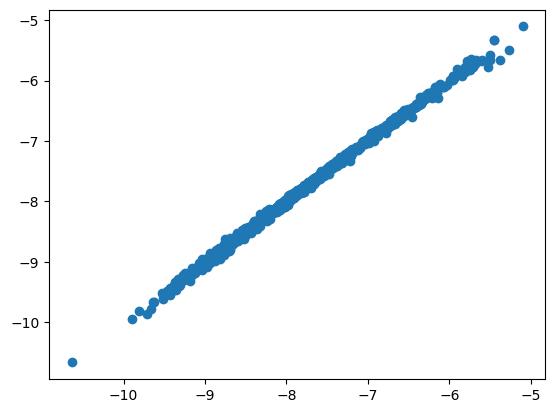

In [25]:
plt.scatter(chgnet,DFT_to_chgnet)

In [26]:
np.mean(np.abs(chgnet-DFT_to_chgnet))

0.028156418088836056